In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.path as mpath
from matplotlib import rc
import matplotlib.pyplot as plt
import netCDF4 as nc 
import pandas as pd 
import xarray as xr
import seaborn as sns
import scipy
from xgcm import Grid
import matplotlib.animation as animation
from IPython.display import HTML
import cmocean
from scipy.fft import fft, fftfreq
plt.rcParams.update({'font.size': 10})
from scipy import signal
print('all done')
%matplotlib inline
nanmasked = plt.get_cmap('turbo').copy()
nanmasked.set_bad('black')
nanmasked2 = plt.get_cmap('RdBu').copy()
nanmasked2.set_bad('black')

all done


In [2]:
from dask.distributed import Client
import dask
import os
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 7.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46241,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41153,Total threads: 1
Dashboard: http://127.0.0.1:42155/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:41859,


In [3]:
# data_path = '/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/OUTPUT/1996-control/19960101.dye_experiments_z_1996_'
data_path = '/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/OUTPUT/1996-control/19960101.ocean_daily_budgets_1996_'
ds = xr.concat([xr.open_dataset(data_path+'{:02}'.format(i)+'.nc',chunks='auto') for i in range(1, 13)],dim='time')
ds = ds.isel(xh=slice(0,601),yh=slice(0,343))#,xq=slice(0,601),yq=slice(0,343))

# ## full static on the native full grid cropped to region
data_path = '/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/OUTPUT/1996-control/19960101.ocean_static.nc'
static = xr.open_dataset(data_path,chunks='auto')
static = static.isel(xh=slice(0,601),yh=slice(0,343),xq=slice(0,601),yq=slice(0,343))

/tmp/ipykernel_3571857/868469965.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.concat([xr.open_dataset(data_path+'{:02}'.format(i)+'.nc',chunks='auto') for i in range(1, 13)],dim='time')
/tmp/ipykernel_3571857/868469965.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.concat([xr.open_dataset(data_path+'{:02}'.format(i)+'.nc',chunks='auto') for i in range(1, 13)],dim='time')
/tmp/ipykernel_3571857/868469965.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.concat([xr.open_dataset(data_path+'{:02}'.f

In [4]:
### defining xgcm grid for best practices 

static['dxt'] = static['dxt'].fillna(0.)
static['dyt'] = static['dyt'].fillna(0.)
static['areacello'] = static['areacello'].fillna(0.)

metrics = {
    ('X',): ['dxt'], # X distances
    ('Y',): ['dyt'], # Y distances
    ('X', 'Y'): ['areacello'] # Areas
}

coords={'X': {'center': 'xh', 'right': 'xq'},
        'Y': {'center': 'yh', 'right': 'yq'},
       'time': {'center':'time'}}

ds = xr.merge([ds,static]) # we have to merge so that the time dimension will be processed correctly

grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])#not periodic because it's a regional model, periodic=['X'])

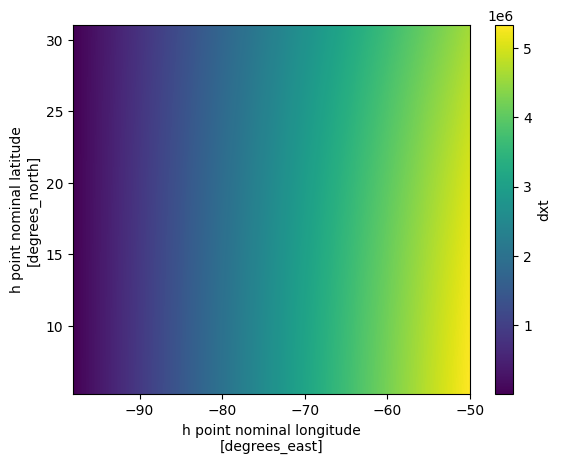

In [7]:
# test = static.dxt.cumsum('xh')
test.plot(x='xh',y='yh')

In [ ]:
h = 0*static.depth_ocean.fillna(0)#.isel(xh=slice(280,300),yh=slice(280,300))
h = (h+static.xh-static.xh.min())
h_x = grid.derivative(grid.interp(h,['X']),'X').persist() # use nondimensional distance
h_x = h_x.isel(xh=slice(280,300),yh=slice(280,300))
h_y = grid.derivative(grid.interp(h,['Y']),'Y').persist() # use nondimensional distance
h_y = h_y.isel(xh=slice(280,300),yh=slice(280,300))
h = h.isel(xh=slice(280,300),yh=slice(280,300))
h = h - h.min()
nx = h_x
ny = h_y
nz = -xr.ones_like(h)
norm = np.sqrt(nx**2 + ny**2 + nz**2)
# h_x.plot(x='xh',y='yh')
# z_norm = -1 + 0*h_mag
# y_norm = h_y2#/np.sqrt(1+h_mag2)
# x_norm = h_x2#/np.sqrt(1+h_mag2)